<html>
<div style="background-image: linear-gradient(to left, rgb(255, 255, 255), rgb(138, 136, 136)); width: 600px; vertical-align: middle; height: 40px; margin: 10px;">
<h1 style="font-family: Georgia; color: black;">AI-Fall 01-CA5</h1>
</div>
<div style="background-image: linear-gradient(to left, rgb(255, 255, 255), rgb(138, 136, 136)); width: 500px; margin: 10px;">
  <img src="https://upload.wikimedia.org/wikipedia/en/thumb/f/fd/University_of_Tehran_logo.svg/225px-University_of_Tehran_logo.svg.png" width=60px width=auto style="padding:10px; vertical-align: middle;">
  <span style="font-family: Georgia; font-size:30px; color: black;">University of Tehran </span>
</div>
<div style=" background-image: linear-gradient(to left, rgb(255, 255, 255), rgb(138, 136, 136)); width: 400px; height: 30px; margin: 10px;">
  <span style="font-family: Georgia; font-size:15pt; color: black; vertical-align: middle;">Saman Eslami Nazari - std id: 810199375 </span>
</div>
</html>

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras

from typing import Optional

# Part 1: Assessing and Preprocessing

In [23]:
DATASET_FOLDER = 'dataset'

train_df = pd.read_csv(f'{DATASET_FOLDER}/TrainImgs.csv', header=None)
train_labels_df = pd.read_csv(f'{DATASET_FOLDER}/TrainLabels.csv', header=None)

test_df = pd.read_csv(f'{DATASET_FOLDER}/TestImgs.csv', header=None)
test_labels_df = pd.read_csv(f'{DATASET_FOLDER}/TestLabels.csv', header=None)

First, I will choose one sample from each class in the train dataset.

In [24]:
unique_classes = train_labels_df[0].unique()

classes_sample = []
classes_sample_label = []
for c in unique_classes:
    index = train_labels_df.index[train_labels_df[0] == c][0]
    classes_sample.append(train_df.iloc[index])
    classes_sample_label.append(train_labels_df[0].iloc[index])


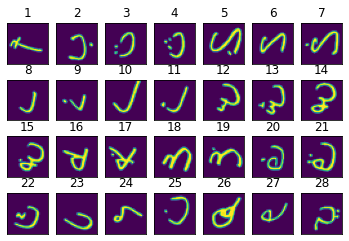

In [25]:
def show_pic(pic: np.array, pic_label: int, axes: plt.Axes) -> None:
    axes.imshow(pic)
    axes.set_title(pic_label)
    axes.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

ncols = 7
nrows = math.ceil(len(unique_classes) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
for i in range(len(unique_classes)):
    pic = np.array(classes_sample[i]).reshape(32, 32)
    show_pic(pic, classes_sample_label[i], axes.flatten()[i])

It is also vital to know the interval of pixels' values.

In [26]:
print(f"Pixels' interval : [{train_df.values.min()}:{train_df.values.max()}]")

Pixels' interval : [0:255]


For simplicity I will consider only the first 16 classes, thus I wil remove the rest.

In [27]:
def trim_classes(df: pd.DataFrame, labels: pd.DataFrame):
    indexes_to_drop = labels.index[labels[0] > 16]
    df.drop(indexes_to_drop, inplace=True)
    labels.drop(indexes_to_drop, inplace=True)

trim_classes(train_df, train_labels_df)
trim_classes(test_df, test_labels_df)

Bar plot for the count of training and testing images within the 16 labels:

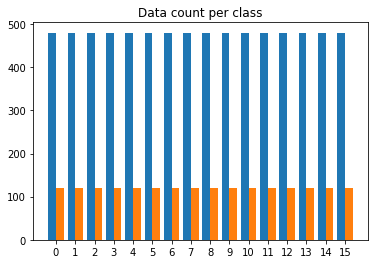

In [28]:
width = 0.4
unique_classes = train_labels_df[0].unique()
x = np.arange(len(unique_classes))
train_count_per_class = train_labels_df[0].value_counts().sort_index()
test_count_per_class = test_labels_df[0].value_counts().sort_index()

plt.bar(x - width/2, train_count_per_class, width, label='train')
plt.bar(x + width/2, test_count_per_class, width, label='test')
plt.xticks(x);
plt.title('Data count per class');


We will now scale and normalize the pixel values.  
This will bring the pixel values in the range of 0 to 1.

Inputs with large values can slow down the learning process or even break it.  
Giving unnormalized inputs to activation functions can get us stuck in a flat region and cease learning.  
Sometimes there can be numerical issues (such as division by zero) as well.  
Normalization also helps the gradient descent process for back propagation.

In [29]:
train_df = train_df / 255
test_df = test_df / 255

One-hot encoding for the 16 first labels:

In [30]:
onehot = np.zeros((train_labels_df[0].size, train_labels_df[0].nunique()))
onehot[np.arange(train_labels_df[0].size), train_labels_df[0].values - 1] = 1
pd.DataFrame(onehot)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


This is done because the labels are not ordinal and a higher number does not imply anything.  
Now the last layer of the neural network can have 16 neurons corresponding to the 16 classes, and whichever gets a higher number will be chosen as the predicted class.

# Part 2. Classes

## Dataloader

In [31]:
class Dataloader:

    def __init__(self,
                 data,
                 labels,
                 n_classes,
                 batch_size,
                 shuffle):
        assert data.shape[0] == labels.shape[0]
        
        self._n_classes = n_classes
        self._batch_size = batch_size
        self._shuffle = shuffle
        self._data = np.matrix(data)
        self._onehot_labels = self._onehot(labels[0], self._n_classes)

    def _onehot(self, labels, n_classes):
        onehot = np.zeros((labels.size, labels.nunique()))
        onehot[np.arange(labels.size), labels.values - 1] = 1
        return onehot

    def _shuffle_dataset(self):
        perm = np.random.permutation((self._data.shape[0]))
        self._data = self._data[perm]
        self._onehot_labels = self._onehot_labels[perm]

    def __iter__(self):
        if self._shuffle:
            self._shuffle_dataset()

        if self._batch_size == None:
            yield (self._data, self._onehot_labels)
            return

        for idx in range(0, self._data.shape[0], self._batch_size):
            yield (self._data[idx:idx+self._batch_size],
                   self._onehot_labels[idx:idx+self._batch_size])

# Phase 2: The Neural Network

## Activation Functions

In [32]:
class Identical:
    
    def __init__(self):
        pass
    
    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


In [33]:
class ReLU:

    def __init__(self):
        pass
    
    def __val(self, matrix):
        relu_value = np.where(matrix < 0, 0, matrix)
        return relu_value

    def derivative(self, matrix):
        relu_derivative = np.where(matrix < 0, 0, 1)
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


In [34]:
class LeakyReLU:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        leaky_relu_func = np.vectorize(lambda x : self.negative_slope * x if x < 0 else x)
        leaky_relu_value = leaky_relu_func(matrix)
        return leaky_relu_value

    def derivative(self, matrix):
        leaky_relu_derivative_func = np.vectorize(lambda x : self.negative_slope if x < 0 else 1)
        leaky_relu_derivative = leaky_relu_derivative_func(matrix)
        return leaky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


In [35]:
class Sigmoid:

    def __init__(self):
        pass

    def __val(self, matrix):
        sigmoid_func = np.vectorize(lambda x: 1/(1+np.exp(-x)))
        sigmoid_value = sigmoid_func(matrix)
        return sigmoid_value

    def derivative(self, matrix):
        sigmoid_derivative_func = np.vectorize(
            lambda x : np.exp(-x)/np.power((np.exp(-x) + 1), 2)
        )
        sigmoid_derivative = sigmoid_derivative_func(matrix)
        return sigmoid_derivative

    def __call__(self, matrix):
        return self.__val(matrix)


In [36]:
class SoftMax:

    def __init__(self):
        pass

    def __val(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        def softmax(row):
            new = row - np.max(row)
            return np.exp(new)/np.sum(np.exp(new))            
        softmax_value = np.apply_along_axis(softmax, 1, temp)
        return softmax_value

    def __call__(self, matrix):
        return self.__val(matrix)


In [37]:
class Tanh:
    
    def __init__(self):
        pass

    def __val(self, matrix):
        tanh_value = np.tanh(matrix)
        return tanh_value

    def derivative(self, matrix):
        tanh_derivative_func = np.vectorize(
            lambda x : 4 / np.power(np.exp(x) + np.exp(-x), 2)
        )
        tanh_derivative = tanh_derivative_func(matrix)
        return tanh_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


## Loss Function

In [38]:
class CrossEntropy:  # (with softmax)

    def __init__(self):
        pass

    def __val(self, true_val, expected_val):
        assert np.shape(true_val) == np.shape(expected_val)
        mat_true_val = np.matrix(true_val)
        mat_expected_val = np.matrix(expected_val)
        mat_true_val = SoftMax()(mat_true_val)
        log = np.log(mat_true_val)
        cross_entropy_value = -1 * np.sum(np.multiply(expected_val, log), axis=1)
        return cross_entropy_value

    def derivative(self, true_val, expected_val):
        assert np.shape(true_val) == np.shape(expected_val)
        mat_true = np.matrix(true_val)
        mat_true = SoftMax()(mat_true)
        mat_expected = np.matrix(expected_val)
        cross_entropy_derivative = mat_true - mat_expected
        return cross_entropy_derivative

    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)


## Layer

In [39]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.

    def __init__(self, input_size, output_size, activation=Identical(), initial_weight='uniform',
                 **initializing_parameters):

        assert type(initial_weight) == str, 'Undefined activation function!'

        self.__weight_initializer_dict = {
            'uniform': self.__uniform_weight, 'normal': self.__normal_weight}

        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'

        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(
            input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(
            1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation

        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None

    def forward(self, layer_input):
        assert np.ndim(layer_input) == 2
        assert np.size(self.__weight, 0) == np.size(layer_input, 1)

        self.__last_input = np.matrix(layer_input)
        self.__last_activation_input = (self.__last_input * self.__weight) + self.__bias
        self.__last_activation_output = self.__activation(
            self.__last_activation_input
        )
        self.__last_activation_derivative = self.__activation.derivative(
            self.__last_activation_input
        )

        return self.__last_activation_output

    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor) == 2
        assert np.size(backprop_tensor, 0) == np.size(
            self.__last_activation_derivative, 0
        )
        assert np.size(backprop_tensor, 1) == self.__n_neurons

        ones = np.matrix(np.ones((np.size(backprop_tensor,axis=0), 1)))

        dy = np.multiply(backprop_tensor, self.__last_activation_derivative)
        db = np.matmul(np.transpose(ones), dy)
        dw = np.matmul(np.transpose(self.__last_input), dy)
        
        backprop_tensor = np.matmul(dy, np.transpose(self.__weight))

        self.__weight -= lr * dw
        self.__bias -= lr * db
        
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys():
            low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys():
            high = initializing_parameters['high']
        weights = np.matrix(np.random.uniform(low, high, size=(dim1, dim2)))
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys():
            mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys():
            var = initializing_parameters['var']
        weights = np.matrix(np.random.normal(mean, np.sqrt(var), size=(dim1, dim2)))
        return weights

    @property
    def n_neurons(self): return self.__n_neurons

    @property
    def weight(self): return self.__weight

    @property
    def bias(self): return self.__bias

    @property
    def activation(self): return self.__activation


## Feed Forward Neural Network

In [40]:
class FeedForwardNN:

    def __init__(self, input_shape):
        self.__input_shape = input_shape
        self.__output_shape = None

        self.__layers_list = []

        self.__lr = None
        self.__loss = None

    def add_layer(self, n_neurons, activation=ReLU(), initial_weight='uniform', **initializing_parameters):
        assert type(
            n_neurons) == int, "Invalid number of neurons for the layer!"
        assert n_neurons > 0, "Invalid number of neurons for the layer!"

        n_prev_neurons = self.__input_shape if len(self.__layers_list) == 0 \
            else self.__layers_list[-1].n_neurons
        new_layer = Layer(
            n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters
        )
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons

    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Incomplete model!"
        self.__loss = loss
        self.__lr = lr

    def forward(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"

        layer_input = network_input
        for l in self.__layers_list:
            layer_input = l.forward(layer_input)
        network_output = layer_input

        return network_output

    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(
            self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy": [], "train_loss": [],
               "test_accuracy": [], "test_loss": []}

        for epoch in range(1, epochs+1):

            if print_results:
                print('Epoch {}:'.format(epoch))

            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(
                    average_accuracy, average_loss))

            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(
                        average_accuracy, average_loss))

        return log

    def __train(self, trainloader):
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(
                x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    def __test(self, testloader):
        batch_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(batch_accuracies), np.mean(batch_losses)

    def __train_on_batch(self, x_batch, y_batch):
        network_output = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(network_output, y_batch)
        batch_average_loss = np.mean(self.__loss(network_output, y_batch))
        self.__update_weights(network_output, y_batch)
        return (batch_accuracy, batch_average_loss)

    def __test_on_batch(self, x_batch, y_batch):
        network_output = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(network_output, y_batch)
        batch_average_loss = np.mean(self.__loss(network_output, y_batch))
        return (batch_accuracy, batch_average_loss)

    def __get_labels(self, outputs):
        labels = outputs.argmax(axis=1)
        return labels

    def __compute_accuracy(self, output, expected_output):
        predicted_labels = self.__get_labels(np.matrix(output))
        expected_labels = self.__get_labels(np.matrix(expected_output))
        accuracy = np.count_nonzero(predicted_labels == expected_labels) * 100 / \
            np.size(expected_labels, axis=0)
        return accuracy

    def __update_weights(self, output, y_train):
        backprop_tensor = self.__loss.derivative(output, y_train)
        for layer in reversed(self.__layers_list):
            backprop_tensor = layer.update_weights(backprop_tensor, self.__lr)
        return


# Phase 3: Classifying Data

In [41]:
def run_network(
    activation_function: ReLU | LeakyReLU | Sigmoid | Tanh,
    epochs: int,
    lr: float,
    batch_size: int) -> None:

    INPUT_SHAPE = 32 * 32
    N_CLASSES = 16
    train_loader = Dataloader(train_df, train_labels_df, N_CLASSES, batch_size, True)
    test_loader = Dataloader(test_df, test_labels_df, N_CLASSES, batch_size, True)

    network = FeedForwardNN(INPUT_SHAPE)
    network.add_layer(40, activation_function, 'uniform')
    network.add_layer(20, activation_function, 'uniform')
    network.add_layer(16, Identical(), 'uniform')
    network.set_training_param(loss=CrossEntropy(), lr=lr)
    log = network.fit(epochs, train_loader, test_loader)


In [42]:
EPOCHS = 10
BATCH_SIZE = 32

run_network(ReLU(), EPOCHS, 0.005, BATCH_SIZE)

Epoch 1:
	Train: Average Accuracy: 9.973958333333334	Average Loss: 2.651851510235027
	Test: Average Accuracy: 12.65625	Average Loss: 2.5172908448686018
Epoch 2:
	Train: Average Accuracy: 19.53125	Average Loss: 2.264071447787922
	Test: Average Accuracy: 25.677083333333332	Average Loss: 2.030436573505536
Epoch 3:
	Train: Average Accuracy: 28.971354166666668	Average Loss: 1.9276563613559645
	Test: Average Accuracy: 32.083333333333336	Average Loss: 1.8066531481798158
Epoch 4:
	Train: Average Accuracy: 35.885416666666664	Average Loss: 1.70308563983712
	Test: Average Accuracy: 37.708333333333336	Average Loss: 1.6430705032652995
Epoch 5:
	Train: Average Accuracy: 45.026041666666664	Average Loss: 1.4632958493425872
	Test: Average Accuracy: 44.270833333333336	Average Loss: 1.435243455440687
Epoch 6:
	Train: Average Accuracy: 51.4453125	Average Loss: 1.274648405555079
	Test: Average Accuracy: 53.958333333333336	Average Loss: 1.2192989106794156
Epoch 7:
	Train: Average Accuracy: 55.72916666666666

### Part 2: The effect of having weights set to zero
If all weights were set to zero, the derivative of each neuron would be the same and thus the back propagation method would have failed. This is the same is getting stuck in a local maxima in the search space.

### Part 3: The effect of the leaning rate

#### Low learning rate:

In [43]:
run_network(ReLU(), EPOCHS, 0.0005, BATCH_SIZE)

Epoch 1:
	Train: Average Accuracy: 6.6796875	Average Loss: 2.7346042241147615
	Test: Average Accuracy: 6.25	Average Loss: 2.7224456208079024
Epoch 2:
	Train: Average Accuracy: 6.028645833333333	Average Loss: 2.716952242578689
	Test: Average Accuracy: 6.25	Average Loss: 2.706099685458523
Epoch 3:
	Train: Average Accuracy: 6.966145833333333	Average Loss: 2.698597610843686
	Test: Average Accuracy: 6.927083333333333	Average Loss: 2.6903570968855344
Epoch 4:
	Train: Average Accuracy: 7.369791666666667	Average Loss: 2.682076301251977
	Test: Average Accuracy: 8.489583333333334	Average Loss: 2.6700120715297166
Epoch 5:
	Train: Average Accuracy: 8.9453125	Average Loss: 2.66414506306456
	Test: Average Accuracy: 9.114583333333334	Average Loss: 2.6500483114825846
Epoch 6:
	Train: Average Accuracy: 10.598958333333334	Average Loss: 2.6440420885784714
	Test: Average Accuracy: 11.197916666666666	Average Loss: 2.630149074076287
Epoch 7:
	Train: Average Accuracy: 11.002604166666666	Average Loss: 2.62245

#### High learning rate

In [44]:
run_network(ReLU(), EPOCHS, 0.5, BATCH_SIZE)

Epoch 1:
	Train: Average Accuracy: 6.028645833333333	Average Loss: 3.675253276262154
	Test: Average Accuracy: 6.25	Average Loss: 3.1474099696778546
Epoch 2:
	Train: Average Accuracy: 5.9765625	Average Loss: 3.150666369622319
	Test: Average Accuracy: 6.25	Average Loss: 2.9087563428865506
Epoch 3:
	Train: Average Accuracy: 6.1328125	Average Loss: 3.1222263227215397
	Test: Average Accuracy: 6.25	Average Loss: 3.119418899479062
Epoch 4:
	Train: Average Accuracy: 5.885416666666667	Average Loss: 3.153979532045519
	Test: Average Accuracy: 6.25	Average Loss: 2.934578890945155
Epoch 5:
	Train: Average Accuracy: 5.9375	Average Loss: 3.1530376464321686
	Test: Average Accuracy: 6.25	Average Loss: 3.660271004701134
Epoch 6:
	Train: Average Accuracy: 5.950520833333333	Average Loss: 3.128254463817231
	Test: Average Accuracy: 6.25	Average Loss: 3.0298914133872867
Epoch 7:
	Train: Average Accuracy: 5.78125	Average Loss: 3.12266410704781
	Test: Average Accuracy: 6.25	Average Loss: 3.0018172979556863
Epo

As it can be sen from the results, the training process takes way longer than usual as it updates the neurons with much smaller steps. Also the model with high learning rate barely observe a change in its accuracy as it can't converge properly and miss the maxima due to its high learning rate.

### Part 4: The effects of different activation functions

In [45]:
run_network(Sigmoid(), EPOCHS, 0.005, BATCH_SIZE)

Epoch 1:
	Train: Average Accuracy: 6.263020833333333	Average Loss: 2.784274686172886
	Test: Average Accuracy: 6.25	Average Loss: 2.7804041809874565
Epoch 2:
	Train: Average Accuracy: 6.484375	Average Loss: 2.781856398535658
	Test: Average Accuracy: 6.25	Average Loss: 2.783611094133973
Epoch 3:
	Train: Average Accuracy: 6.5625	Average Loss: 2.778955354995986
	Test: Average Accuracy: 6.25	Average Loss: 2.7754473091108673
Epoch 4:
	Train: Average Accuracy: 6.223958333333333	Average Loss: 2.774671123528523
	Test: Average Accuracy: 6.25	Average Loss: 2.7678054173192113
Epoch 5:
	Train: Average Accuracy: 7.8515625	Average Loss: 2.765220447707628
	Test: Average Accuracy: 9.6875	Average Loss: 2.757223503787394
Epoch 6:
	Train: Average Accuracy: 9.0234375	Average Loss: 2.751429202989877
	Test: Average Accuracy: 8.854166666666666	Average Loss: 2.740420226641902
Epoch 7:
	Train: Average Accuracy: 9.895833333333334	Average Loss: 2.733341928640517
	Test: Average Accuracy: 13.177083333333334	Average

In [46]:
run_network(Tanh(), EPOCHS, 0.005, BATCH_SIZE)

Epoch 1:
	Train: Average Accuracy: 7.6171875	Average Loss: 2.734107232656607
	Test: Average Accuracy: 12.239583333333334	Average Loss: 2.5972573113090633
Epoch 2:
	Train: Average Accuracy: 12.721354166666666	Average Loss: 2.44241275234304
	Test: Average Accuracy: 14.114583333333334	Average Loss: 2.340789229598266
Epoch 3:
	Train: Average Accuracy: 19.010416666666668	Average Loss: 2.2084578174277625
	Test: Average Accuracy: 28.229166666666668	Average Loss: 1.9488411838067417
Epoch 4:
	Train: Average Accuracy: 29.231770833333332	Average Loss: 1.8680059578963584
	Test: Average Accuracy: 32.8125	Average Loss: 1.760528677143237
Epoch 5:
	Train: Average Accuracy: 37.473958333333336	Average Loss: 1.6529229167700057
	Test: Average Accuracy: 40.677083333333336	Average Loss: 1.5185636779084668
Epoch 6:
	Train: Average Accuracy: 45.611979166666664	Average Loss: 1.4093784852119895
	Test: Average Accuracy: 48.645833333333336	Average Loss: 1.37460247304571
Epoch 7:
	Train: Average Accuracy: 51.06770

In [47]:
run_network(LeakyReLU(), EPOCHS, 0.005, BATCH_SIZE)

Epoch 1:
	Train: Average Accuracy: 9.427083333333334	Average Loss: 2.652358629230238
	Test: Average Accuracy: 11.875	Average Loss: 2.52819965411359
Epoch 2:
	Train: Average Accuracy: 13.424479166666666	Average Loss: 2.427623208269361
	Test: Average Accuracy: 20.833333333333332	Average Loss: 2.1448251277645096
Epoch 3:
	Train: Average Accuracy: 24.895833333333332	Average Loss: 2.0321930916050754
	Test: Average Accuracy: 29.6875	Average Loss: 1.8533905552884566
Epoch 4:
	Train: Average Accuracy: 32.174479166666664	Average Loss: 1.7860344638009438
	Test: Average Accuracy: 36.197916666666664	Average Loss: 1.7005923861819034
Epoch 5:
	Train: Average Accuracy: 39.518229166666664	Average Loss: 1.5748181869454165
	Test: Average Accuracy: 41.510416666666664	Average Loss: 1.4761820662530434
Epoch 6:
	Train: Average Accuracy: 45.78125	Average Loss: 1.387683867297523
	Test: Average Accuracy: 48.229166666666664	Average Loss: 1.3892888613621701
Epoch 7:
	Train: Average Accuracy: 53.111979166666664	A

# Phase 4: Using Tensorflow and Keras

## Part 1: Preparing Data and Designing the Neural Network

In [48]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()


In [49]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print(f"x_train new shape: {x_train.shape}")
print(f"x_test new shape: {x_test.shape}")


x_train new shape: (50000, 3072)
x_test new shape: (10000, 3072)


In [50]:
x_train_norm = x_train / 255
x_test_norm = x_test / 255


In [51]:
n_classes = len(np.unique(y_train))
one_hot_y_train = tf.keras.utils.to_categorical(y_train, n_classes)
one_hot_y_test = tf.keras.utils.to_categorical(y_test, n_classes)


In [52]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            50, input_dim=32*32*3, activation=keras.activations.relu
        ),
        keras.layers.Dense(30, activation=keras.activations.relu),
        keras.layers.Dense(n_classes, activation=keras.activations.softmax)
    ]
)

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss=keras.losses.categorical_crossentropy, metrics=['accuracy']
)


In [53]:
model.fit(x_train_norm, one_hot_y_train, validation_data=(x_test_norm, one_hot_y_test), epochs=10, batch_size=32)


Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.9485 - accuracy: 0.2954 - val_loss: 1.8437 - val_accuracy: 0.3330
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.7638 - accuracy: 0.3708 - val_loss: 1.7216 - val_accuracy: 0.3855
Epoch 3/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.6944 - accuracy: 0.3969 - val_loss: 1.6598 - val_accuracy: 0.4030
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.6482 - accuracy: 0.4133 - val_loss: 1.6356 - val_accuracy: 0.4128
Epoch 5/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.6077 - accuracy: 0.4287 - val_loss: 1.6376 - val_accuracy: 0.4147
Epoch 6/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.5790 - accuracy: 0.4371 - val_loss: 1.5681 - val_accuracy: 0.4451
Epoch 7/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.5549 - accuracy: 0.4478 - val_loss: 1.6095 - val_accuracy:

In [54]:
y_train_pred = model.predict(x_train)
y_train_pred = np.argmax(y_train_pred, axis=1)
print(classification_report(y_train, y_train_pred))


1563/1563 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

           0       0.33      0.47      0.39      5000
           1       0.41      0.70      0.52      5000
           2       0.46      0.11      0.18      5000
           3       0.34      0.12      0.18      5000
           4       0.51      0.24      0.33      5000
           5       0.29      0.44      0.35      5000
           6       0.76      0.14      0.23      5000
           7       0.60      0.42      0.49      5000
           8       0.33      0.85      0.48      5000
           9       0.48      0.41      0.44      5000

    accuracy                           0.39     50000
   macro avg       0.45      0.39      0.36     50000
weighted avg       0.45      0.39      0.36     50000



In [55]:
y_test_pred = model.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1)
print(classification_report(y_test, y_test_pred))


313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.33      0.48      0.40      1000
           1       0.40      0.68      0.51      1000
           2       0.44      0.11      0.18      1000
           3       0.35      0.13      0.19      1000
           4       0.47      0.22      0.30      1000
           5       0.27      0.42      0.33      1000
           6       0.68      0.14      0.23      1000
           7       0.57      0.38      0.46      1000
           8       0.32      0.83      0.46      1000
           9       0.47      0.37      0.42      1000

    accuracy                           0.38     10000
   macro avg       0.43      0.38      0.35     10000
weighted avg       0.43      0.38      0.35     10000



## Part 2: Checking on different changes

### Momentum and its effects
momentum is a method used to speed up training of neural networks. It helps to avoid getting stuck in local minima by building up momentum as the optimizer traverses the loss surface. The momentum term allows the optimizer to continue moving in the same direction even if the gradient changes sign, which can help to prevent the optimizer from oscillating or getting stuck in a suboptimal solution. It is often used in conjunction with other optimization algorithms such as stochastic gradient descent (SGD) and is typically set to a value between 0 and 1.

In [56]:
model_momentum = keras.Sequential(
    [
        keras.layers.Dense(
            50, input_dim=32*32*3, activation=keras.activations.relu
        ),
        keras.layers.Dense(30, activation=keras.activations.relu),
        keras.layers.Dense(n_classes, activation=keras.activations.softmax)
    ]
)

model_momentum.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.5),
    loss=keras.losses.categorical_crossentropy, metrics=['accuracy']
)

model_momentum.fit(x_train_norm, one_hot_y_train, validation_data=(x_test_norm, one_hot_y_test), epochs=10, batch_size=32)

Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.9047 - accuracy: 0.3133 - val_loss: 1.7599 - val_accuracy: 0.3735
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.7244 - accuracy: 0.3816 - val_loss: 1.7558 - val_accuracy: 0.3639
Epoch 3/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.6456 - accuracy: 0.4126 - val_loss: 1.6362 - val_accuracy: 0.4175
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.5946 - accuracy: 0.4319 - val_loss: 1.6003 - val_accuracy: 0.4315
Epoch 5/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.5556 - accuracy: 0.4452 - val_loss: 1.5332 - val_accuracy: 0.4540
Epoch 6/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.5306 - accuracy: 0.4536 - val_loss: 1.5683 - val_accuracy: 0.4459
Epoch 7/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.5027 - accuracy: 0.4645 - val_loss: 1.5786 - val_accuracy:

Lets check our model's parameters count.

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                153650    
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
Total params: 155,490
Trainable params: 155,490
Non-trainable params: 0
_________________________________________________________________


Total parameters of $Layer_i$ is equal to $dim[Layer_{i-1}] \times dim[Weights\ matrix\ layer_i] + dim[Layer_i]$.
$$\rightarrow Layer_1\ params = (32\times 32\times 3) \times 50 + 50 = 153650$$
$$\rightarrow Layer_2\ params = 50\times 30 + 30 = 1530$$
$$\rightarrow Layer_3\ params = 30\times 10 + 10 = 310$$

In [57]:
model_momentum = keras.Sequential(
    [
        keras.layers.Dense(
            50, input_dim=32*32*3, activation=keras.activations.relu
        ),
        keras.layers.Dense(30, activation=keras.activations.relu),
        keras.layers.Dense(n_classes, activation=keras.activations.softmax)
    ]
)

model_momentum.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss=keras.losses.categorical_crossentropy, metrics=['accuracy']
)

model_momentum.fit(x_train_norm, one_hot_y_train, validation_data=(x_test_norm, one_hot_y_test), epochs=10, batch_size=32)

Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.9302 - accuracy: 0.2855 - val_loss: 1.8363 - val_accuracy: 0.3289
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.7993 - accuracy: 0.3457 - val_loss: 1.7702 - val_accuracy: 0.3469
Epoch 3/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.7593 - accuracy: 0.3613 - val_loss: 1.7474 - val_accuracy: 0.3680
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.7438 - accuracy: 0.3659 - val_loss: 1.6980 - val_accuracy: 0.3873
Epoch 5/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.7265 - accuracy: 0.3727 - val_loss: 1.6805 - val_accuracy: 0.3851
Epoch 6/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.7043 - accuracy: 0.3824 - val_loss: 1.7592 - val_accuracy: 0.3711
Epoch 7/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.6976 - accuracy: 0.3824 - val_loss: 1.6781 - val_accuracy:

In [58]:
model_momentum = keras.Sequential(
    [
        keras.layers.Dense(
            50, input_dim=32*32*3, activation=keras.activations.relu
        ),
        keras.layers.Dense(30, activation=keras.activations.relu),
        keras.layers.Dense(n_classes, activation=keras.activations.softmax)
    ]
)

model_momentum.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.98),
    loss=keras.losses.categorical_crossentropy, metrics=['accuracy']
)

model_momentum.fit(x_train_norm, one_hot_y_train, validation_data=(x_test_norm, one_hot_y_test), epochs=10, batch_size=32)

Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 2.1989 - accuracy: 0.1536 - val_loss: 2.3061 - val_accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 2.3076 - accuracy: 0.0977 - val_loss: 2.3065 - val_accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 3s 2ms/step - loss: 2.3068 - accuracy: 0.0985 - val_loss: 2.3036 - val_accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 2.3060 - accuracy: 0.0996 - val_loss: 2.3056 - val_accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 4s 2ms/step - loss: 2.3059 - accuracy: 0.1010 - val_loss: 2.3057 - val_accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 2.3063 - accuracy: 0.1004 - val_loss: 2.3065 - val_accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 4s 2ms/step - loss: 2.3056 - accuracy: 0.0989 - val_loss: 2.3048 - val_accuracy:

Increasing the momentum term in neural network training does not always lead to better performance. A momentum value that is too high can cause the optimizer to overshoot the optimal solution and may lead to unstable or divergent behavior. Similarly, a momentum value that is too low may result in slow convergence or getting stuck in a suboptimal solution.

### Epoch's Effects
In neural network training, an epoch refers to a complete iteration through the entire training dataset. During each epoch, the model's parameters are updated based on the error calculated on the training data.

The number of epochs to train a neural network for can have a significant impact on the performance of the model. Training for too few epochs can result in underfitting, where the model has not had enough exposure to the training data to learn the underlying patterns. On the other hand, training for too many epochs can result in overfitting, where the model has memorized the training data and is not able to generalize well to new, unseen data.

Different values of epochs can be used to adjust the trade-off between underfitting and overfitting. Some common values include:

- A small number of epochs (e.g. 10-20) to quickly get a sense of whether the model is working well or not.
- A medium number of epochs (e.g. 50-100) to get a more accurate estimate of the model's performance.
- A large number of epochs (e.g. 200-500) to train the model for a long time and achieve the best possible performance.

### Loss Function Effects

In [59]:
model_mse = keras.Sequential(
    [
        keras.layers.Dense(
            50, input_dim=32*32*3, activation=keras.activations.relu
        ),
        keras.layers.Dense(30, activation=keras.activations.relu),
        keras.layers.Dense(n_classes, activation=keras.activations.softmax)
    ]
)

model_mse.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss=keras.losses.mse, metrics=['accuracy']
)

model_mse.fit(x_train_norm, one_hot_y_train, validation_data=(x_test_norm, one_hot_y_test), epochs=10, batch_size=32)

Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0889 - accuracy: 0.1697 - val_loss: 0.0879 - val_accuracy: 0.1923
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0873 - accuracy: 0.2087 - val_loss: 0.0866 - val_accuracy: 0.2190
Epoch 3/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0861 - accuracy: 0.2252 - val_loss: 0.0856 - val_accuracy: 0.2315
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0851 - accuracy: 0.2390 - val_loss: 0.0847 - val_accuracy: 0.2438
Epoch 5/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0843 - accuracy: 0.2534 - val_loss: 0.0839 - val_accuracy: 0.2606
Epoch 6/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0834 - accuracy: 0.2706 - val_loss: 0.0830 - val_accuracy: 0.2834
Epoch 7/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0825 - accuracy: 0.2876 - val_loss: 0.0821 - val_accuracy:

Mean Squared Error (MSE) is a commonly used loss function for regression problems, where the goal is to predict a continuous output value. However, it is not a good loss function for classification problems, where the goal is to predict a discrete class label.

The main issue with using MSE for classification is that it does not take into account the fact that the output of a classification model is discrete and not continuous. MSE is sensitive to the scale of the output values, which can lead to issues when the predicted class probabilities are close to 0 or 1. MSE also does not provide a clear measure of the model's classification performance, as it does not penalize false positives and false negatives differently.

### Regularization Effects
Dropout is a technique used to prevent overfitting in neural networks. The idea behind dropout is to randomly drop out, or "turn off," a certain percentage of neurons in the network during training. This is done by setting the output of a randomly selected subset of neurons to zero for each training iteration. The effect of this is to force the network to learn multiple independent representations of the input data, rather than relying on a small number of neurons.

Dropout has several effects on a neural network:

- By randomly dropping out neurons during training, dropout introduces a form of randomness into the training process, which helps to prevent overfitting.
- Dropout reduces the co-adaptation of neurons, meaning that during the training process, different neurons learn different features which increases the model's robustness.
- Dropout also acts as a form of regularization, which helps to reduce the generalization error of the model.
- It reduces the possibility of overfitting by preventing the co-adaptation of neurons in the network.

In [60]:
model_reg = keras.Sequential(
    [
        keras.layers.Dense(
            50,
            input_dim=32*32*3,
            activation=keras.activations.relu
        ),
        keras.layers.Dropout(
            rate=0.1
        ),
        keras.layers.Dense(
            30,
            activation=keras.activations.relu
        ),
        keras.layers.Dropout(
            rate=0.1
        ),
        keras.layers.Dense(
            n_classes,
            activation=keras.activations.softmax
        )
    ]
)

model_reg.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss=keras.losses.mse, metrics=['accuracy']
)

model_reg.fit(x_train_norm, one_hot_y_train, validation_data=(
    x_test_norm, one_hot_y_test), epochs=10, batch_size=32
)


Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0897 - accuracy: 0.1476 - val_loss: 0.0888 - val_accuracy: 0.1952
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0887 - accuracy: 0.1787 - val_loss: 0.0879 - val_accuracy: 0.2218
Epoch 3/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0879 - accuracy: 0.1987 - val_loss: 0.0869 - val_accuracy: 0.2342
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0871 - accuracy: 0.2091 - val_loss: 0.0861 - val_accuracy: 0.2482
Epoch 5/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0864 - accuracy: 0.2252 - val_loss: 0.0852 - val_accuracy: 0.2585
Epoch 6/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0857 - accuracy: 0.2356 - val_loss: 0.0843 - val_accuracy: 0.2717
Epoch 7/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0851 - accuracy: 0.2445 - val_loss: 0.0837 - val_accuracy:

As previously mentioned, dropout helps to regularize the model, reducing its capacity and forcing it to learn multiple independent representations of the input data. This can improve the model's generalization performance, which is the ability of the model to perform well on unseen data. So, dropout can make the model more robust and less overfitting by trading off a little bit of accuracy on the training set, but it can result in better performance on unseen data. This can be seen in the above results in which we have encountered a drop in accuracy.